### Cab-Driver Agent

In [ ]:
#File Paths
timeMatrix_path = "inputs/TM.npy"

# Importing the environment
from references.Env import CabDriver

# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

#Test Libs
import sys
import os
import time
import copy
from sklearn.preprocessing import OneHotEncoder 

#### Defining Time Matrix

In [2]:
# Call the environment
env = CabDriver()

In [3]:
# Loading the time matrix provided
Time_matrix = np.load(timeMatrix_path)

#### Tracking the state-action pairs for checking convergence


In [4]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
States_track = collections.defaultdict(dict)
Rewards_track = collections.defaultdict(dict)

print(len(States_track))
print(len(Rewards_track))

0
0


In [5]:
# Initialise states to be tracked
def initialise_tracking_states():
#     self.track_state = np.array(env.state_encod_arch1([0,7,4])).reshape(1, 36)
    sample_states = [(0, 7, 4),(1, 2, 5)]
    for state in sample_states:
        for action in env.action_space:
            States_track[state][action] = []
    Rewards_track['Rewards'] = []
    Rewards_track['Episode'] = []

# Defining a function to track the states initialized
def save_tracking_states(state, qval):
    if state in States_track.keys():
        for i,action in enumerate(States_track[state].keys()):
            States_track[state][action].append(qval[0][i])
            
# Defining a function to track the states initialized
def save_total_rewards(total_reward, episode_num):
    Rewards_track['Rewards'].append(total_reward)
    Rewards_track['Episode'].append(episode_num)

#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(name + '.h5', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
initialise_tracking_states()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size 

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.02      
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0009
        self.epsilon_min = 0.001
        self.batch_size = 32      
        self.epsilon = 0.001
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(200,activation='relu',input_dim=(self.state_size), kernel_initializer='he_uniform'))
        model.add(Dense(150,activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(100,activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation = 'linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state):
        # Write your code here:
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay *episode)
        self.z = np.random.random()  
        possible_actions_index, possible_actions = env.requests(state)

        # get action from model using epsilon-greedy policy
        if self.z > self.epsilon:
            #Greedy action
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
#             print("q_value")
#             print(q_value)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
#             print(q_vals_possible)
            actionIndex = possible_actions_index[np.argmax(q_vals_possible)]
            action = env.action_space[actionIndex]
            
        # Decay in ε after we generate each sample from the environment       
        else:
            #Random
            action = random.choice(possible_actions)
        return action
        
    def append_sample(self, state, action, reward, next_state,terminal_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,terminal_state))
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size: 
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, terminal_states = [], [], []
            
            #TRAIN THE MODEL
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
#                 print(actions)
                actions.append(env.action_space.index(action))
                rewards.append(reward)
                terminal_states.append(terminal_state)
#                 print("old_next_state")
#                 print(next_state)
#                 print("new_next_state")
                
                # Write your code from here
                #1. Update your 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
            
            # 2. Predict the target from earlier model
            target = self.model.predict(update_input)
            target_nextqval = self.model.predict(update_output)
            
            # 3. Get the target for the Q-network
            for i in range(self.batch_size):
                if terminal_state:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor* np.max(target_nextqval[i])
            
            # 4. Fit your model and track the loss values
#             print("update_input")
#             print(update_input[0])
#             print("target")
            self.model.fit(update_input, target, batch_size = self.batch_size, epochs=1, verbose=0 )

    def save(self, name):
        self.model.save(name+".h5")

In [7]:
Episodes = 10000

### DQN block

In [ ]:
start_time = time.time()
for episode in range(Episodes):
    # Write code here    
    
    # Call all the initialised variables of the environment
    action_space = copy.deepcopy(env.action_space)
    state_space = copy.deepcopy(env.state_space)
    curr_state = env.state_init
    action_size = len(action_space)
    state_size = len(env.state_encod_arch1(env.state_init))
    terminal_state = False
    episode_time = 0
    total_reward = 0
    
    #Call the DQN agent
    agent = DQNAgent(state_size,action_size)
    
    while not terminal_state:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(curr_state)
#         print(action)
        
        # 2. Evaluate your reward and next state
        reward = env.reward_func(curr_state, action, Time_matrix)
        next_state,time_lapsed = env.next_state_func(curr_state, action, Time_matrix)
        
        episode_time += time_lapsed
        
        if episode_time > 720:
            terminal_state = True
        else:
            # 3. Append the experience <s,a,s',r,t> to the memory 
            agent.append_sample(curr_state, action, reward, next_state, terminal_state)

            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            
            # 5. Keep a track of rewards, Q-values, loss
            total_reward += reward
            next_state = curr_state

    #TRACKING Q-VALUES      
    if ((episode+1) % 20) == 0:
        save_total_rewards(total_reward,episode)
        for s in States_track.keys():
            state_encoded = np.array(env.state_encod_arch1(s)).reshape(1, 36)
            qval = agent.model.predict(state_encoded)
            save_tracking_states(s, qval)
        save_obj(Rewards_track,'Reward_tracked')
        save_obj(States_track,'States_tracked')
        #Save Model Weights
        agent.save('model_weights')
    
    elapsed_time = time.time() - start_time
    if ((episode+1) % 20) == 0:   
        print("Episode: "+str(episode)+" | Reward: "+str(total_reward)+" | Epsilon: "+str(round(agent.epsilon,2)) 
             +" | Time: "+str(round(elapsed_time,2)))


Episode: 19 | Reward: 386.0 | Epsilon: 0.98 | Time: 170.13
Episode: 39 | Reward: 186.0 | Epsilon: 0.97 | Time: 346.44
Episode: 59 | Reward: 53.0 | Epsilon: 0.95 | Time: 520.12
Episode: 79 | Reward: 240.0 | Epsilon: 0.93 | Time: 699.52
Episode: 99 | Reward: 364.0 | Epsilon: 0.91 | Time: 874.1
Episode: 119 | Reward: 306.0 | Epsilon: 0.9 | Time: 1051.53
Episode: 139 | Reward: 418.0 | Epsilon: 0.88 | Time: 1225.74
Episode: 159 | Reward: -28.0 | Epsilon: 0.87 | Time: 1402.78
Episode: 179 | Reward: 276.0 | Epsilon: 0.85 | Time: 1582.9
Episode: 199 | Reward: 197.0 | Epsilon: 0.84 | Time: 1766.93
Episode: 219 | Reward: 409.0 | Epsilon: 0.82 | Time: 1950.02
Episode: 239 | Reward: 249.0 | Epsilon: 0.81 | Time: 2134.14
Episode: 259 | Reward: 281.0 | Epsilon: 0.79 | Time: 2316.19
Episode: 279 | Reward: 358.0 | Epsilon: 0.78 | Time: 2495.62
Episode: 299 | Reward: 370.0 | Epsilon: 0.76 | Time: 2675.44
Episode: 319 | Reward: 541.0 | Epsilon: 0.75 | Time: 2853.49
Episode: 339 | Reward: 209.0 | Epsilon

### Tracking Convergence

WARNING:tensorflow:5 out of the last 19 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019E65037948> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,500)
epsilon = []
for i in range(0,500):
    epsilon.append(0.001 + (1 - 0.001) * np.exp(-0.009*i))

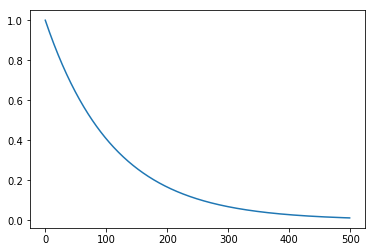

In [16]:
plt.plot(time, epsilon)
plt.show()

In [11]:
with open('Reward_tracked.h5', 'rb') as handle:
    Rewards = pickle.load(handle)
with open('States_tracked.h5', 'rb') as handle:
    States_track = pickle.load(handle)    
# with open('model_weights.h5', 'rb') as handle:
#     model_weights = pickle.load(handle)   
    
print(len(Rewards))
print(len(States_track))

840
2


In [ ]:
plt.plot(Rewards['Episode'], Rewards['Rewards'])
plt.show()